In [1]:
import pandas as pd
from scipy.spatial.distance import cosine
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import numpy as np
import umap
from adjustText import adjust_text


Bad key "text.kerning_factor" on line 4 in
/l/nx/user/jingy/anaconda3/envs/allennlp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# df_srl_emb_dem = pickle.load(open('srl_elmo_dem_sample.tsv','rb'))

In [3]:
# len(df_srl_emb_dem)

In [4]:
df_srl_emb_rep = pickle.load(open('srl_elmo_rep_sample.tsv','rb'))

In [5]:
def build_df_args(df):
    args_list_all = []
    for idx, row in df.iterrows():
        annotation = eval(row['Verb_annotation'])
        verb = annotation['verb']
        verb_idx = eval(row['Text']).index(verb)
        verb_emb = row['Embeddings'][verb_idx]
        arg0_idx = [idx for (idx, tag) in enumerate(annotation['tags']) if 'ARG0' in tag]
        if len(arg0_idx) > 0 and len(arg0_idx) <= 3:
            arg0_emb = np.array([row['Embeddings'][idx] for idx in arg0_idx])
            if arg0_emb.shape[0] > 1:
                arg0_emb = np.sum(arg0_emb, axis=0)
                arg0_emb = np.expand_dims(arg0_emb, axis=0)
            arg0_tok = [eval(row['Text'])[idx] for idx in arg0_idx]
            arg0_tok = ' '.join([item for item in arg0_tok])
        else:
            arg0 = 'No_arg0'
            arg0_idx = -1
            arg0_emb = -1
            arg0_tok = 'No_arg0'


        arg1_idx = [idx for (idx, tag) in enumerate(annotation['tags']) if 'ARG1' in tag]
        if len(arg1_idx) > 0  and len(arg1_idx) <= 3:
            arg1_emb = np.array([row['Embeddings'][idx] for idx in arg1_idx])
            if arg1_emb.shape[0] > 1:
                arg1_emb = np.sum(arg1_emb, axis=0)
                arg1_emb = np.expand_dims(arg1_emb, axis=0)
            arg1_tok = [eval(row['Text'])[idx] for idx in arg1_idx]
            arg1_tok = ' '.join([item for item in arg1_tok])

        else:
            arg1 = 'No_arg1'
            arg1_idx = -1
            arg1_emb = -1
            arg1_tok = 'No_arg1'
        
        text = ' '.join([w for w in eval(row['Text'])])

        args_list_all.append([verb, verb_idx, verb_emb, arg0_tok, arg0_idx, arg0_emb, arg1_tok, \
                              arg1_idx, arg1_emb, text])
    return pd.DataFrame(args_list_all, columns=['Verb', 'Verb_idx', 'Verb_emb', 'Arg0_tok', 'Arg0_idx',\
                                               'Arg0_emb', 'Arg1_tok', 'Arg1_idx', 'Arg1_emb', 'Text'])

In [6]:
# df_args_dem = build_df_args(df_srl_emb_dem)

In [7]:
# df_args_dem['Party'] = 'dem'

In [8]:
# df_args_dem.head()

In [9]:
df_args_rep = build_df_args(df_srl_emb_rep)

In [10]:
df_args_rep['Party'] = 'rep'

In [11]:
# df_args = pd.concat([df_args_rep, df_args_dem])

In [12]:
temp = df_args_rep[df_args_rep['Verb'] == 'fight']

In [16]:
temp.head(10)

In [15]:
for idx, row in temp.head(10).iterrows():
    try:
        print(row['Arg0_tok'], row['Verb'], row['Arg1_tok'])
        print(row['Text'])
        print()
    except:
        pass


In [22]:
def extract_verb_agents(df, verb, arg_option):
    df_verb =df[df.Verb == verb]
    df_verb = df_verb[df_verb['Arg{}_idx'.format(arg_option)] != -1]
    df_verb_agg = df_verb.groupby(['Arg{}_tok'.format(arg_option),'Party'] ).apply\
                                    (lambda x: np.average(x['Arg{}_emb'.format(arg_option)], axis=0)).reset_index()
    df_verb_agg.columns = ['Arg{}_tok'.format(arg_option), 'Party', 'Arg{}_emb'.format(arg_option)]
    pca_reduc = PCA(n_components=30).fit_transform(np.array(df_verb_agg['Arg{}_emb'.format(arg_option)].tolist()).squeeze())
    umap_reduc = umap.UMAP(min_dist=0.0,n_neighbors=5).fit_transform(pca_reduc)
    df_verb_agg['umap_emb_x'] = umap_reduc[:,0]
    df_verb_agg['umap_emb_y'] = umap_reduc[:,1]
    return df_verb_agg

In [34]:
df_verb_agg = extract_verb_agents(df_args, 'fight', 1)

In [35]:
df_verb_agg.head(2)

,Arg1_tok,Party,Arg1_emb,umap_emb_x,umap_emb_y
0,#,rep,"[[-0.021193335, 0.44778198, 0.08882776, 0.1859...",14.407893,3.818871
1,# COVID-19,rep,"[[0.4196708, -0.15163812, -0.13383895, 0.30714...",12.870883,9.453170


In [36]:
# df_args[(df_args['Arg0_tok'] == 'Mitch') & (df_args['Verb'] == 'fighting')]

In [37]:
# ' '.join(item for item in eval(df_srl_emb.iloc[34590]['Text']))

In [38]:
def plot_agent_verb(df, verb, arg_option):
    df_dem = df[df['Party'] == 'dem']
    df_rep = df[df['Party'] == 'rep']
    if len(df_dem) > 50:
        df_dem = df_dem.sample(50)
    if len(df_rep) > 50:
        df_rep = df_rep.sample(50)

    plt.figure(figsize=(15, 15))
    x_dem = df_dem['umap_emb_x'].tolist()
    y_dem = df_dem['umap_emb_y'].tolist()
    text_dem = df_dem['Arg{}_tok'.format(arg_option)].tolist()
    plt.scatter(x_dem,y_dem, s=10, c='blue')
    texts_dem = [plt.text(x_dem[idx], y_dem[idx], text_dem[idx], fontsize=12, c='blue') for idx in range(len(text_dem))]
    
    x_rep = df_rep['umap_emb_x'].tolist()
    y_rep = df_rep['umap_emb_y'].tolist()
    text_rep = df_rep['Arg{}_tok'.format(arg_option)].tolist()
    plt.scatter(x_rep,y_rep, s=10, c='red')
    texts_rep = [plt.text(x_rep[idx], y_rep[idx], text_rep[idx], fontsize=12, c='red') for idx in range(len(text_rep))]
    
    plt.title('Arg {} of verb {}'.format(arg_option, verb))
    all_texts = texts_dem + texts_rep
    adjust_text(all_texts, expand_text=(1.02, 1.02), force_text=(0.75, 0.75), lim=20)

    plt.savefig('arg_{}_verb_{}_both_party.png'.format(arg_option, verb), format='png')

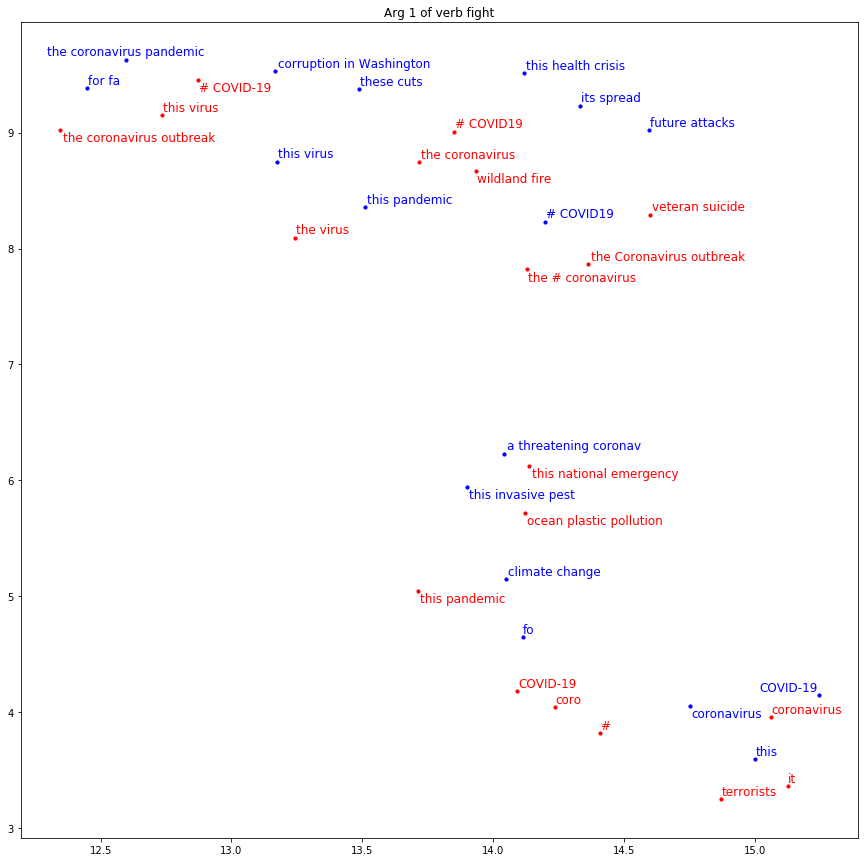

In [41]:
plot_agent_verb(df_verb_agg, 'fight', 1)

In [40]:
for idx, row in pd.DataFrame(df_args.Verb.value_counts().head(100)).iterrows():
    print(row.name, row.values)

is [2784]
are [1878]
have [1176]
be [1163]
will [1157]
can [833]
has [828]
help [677]
need [646]
do [600]
was [555]
get [486]
should [482]
must [431]
been [417]
working [374]
’m [357]
's [333]
Thank [315]
keep [313]
make [302]
would [275]
protect [262]
continue [258]
ensure [254]
’re [235]
provide [230]
see [226]
take [221]
work [219]
know [213]
'm [175]
support [174]
’ve [173]
want [172]
passed [171]
’s [169]
being [168]
am [166]
stop [162]
going [161]
discuss [152]
including [150]
’ll [147]
made [146]
doing [145]
needs [144]
were [143]
're [142]
had [139]
go [138]
does [138]
pass [137]
join [135]
needed [124]
stay [122]
hear [121]
fighting [120]
receive [119]
could [117]
fight [117]
did [117]
put [117]
address [117]
said [116]
let [114]
come [112]
taking [105]
joined [104]
paid [104]
done [103]
ca [103]
getting [103]
calling [102]
may [100]
helping [100]
give [100]
Read [96]
talk [95]
vote [93]
thank [92]
making [92]
use [91]
prevent [89]
call [88]
pay [87]
Let [86]
Do [84]
introduce